In [1]:
# Compare hardness characterization by removing the "hard" points first
import numpy as np
import pandas as pd

X_train = np.load('../data/processed/train.npz')['x']
y_train = np.load('../data/processed/train.npz')['y']
X_v = np.load('../data/processed/v.npz')['x']
y_v = np.load('../data/processed/v.npz')['y']

knn_1 = pd.read_csv('../outputs/results/knn_1.csv')['0']
knn_5 = pd.read_csv('../outputs/results/knn_5.csv')['0']
knn_100 = pd.read_csv('../outputs/results/knn_100.csv')['0']
uncertainty = pd.read_csv('../outputs/results/aleatoric.csv')['0']
confidence = pd.read_csv('../outputs/results/confidence.csv')['0']
forget = pd.read_csv('../outputs/results/forget.csv')['0']
learnt = pd.read_csv('../outputs/results/learnt.csv')['0']

In [2]:
# KNN - Hardest first
ind_knn_1 = list(knn_1.sort_values(ascending=True).index)
ind_knn_5 = list(knn_5.sort_values(ascending=True).index)
ind_knn_100 = list(knn_100.sort_values(ascending=True).index)

# DataIQ - Divide in Hard/Easy/Ambiguous
uncertainty_thresh = 0.2
thresh = 0.25
conf_thresh_low = thresh
conf_thresh_high = 1 - thresh
conf_thresh = 0.5

hard_scores = confidence[(confidence <= conf_thresh_low) & (uncertainty <= uncertainty_thresh)]
easy_scores = confidence[(confidence >= conf_thresh_high) & (uncertainty <= uncertainty_thresh)]
ambig_scores = uncertainty[((confidence > conf_thresh_low) & (confidence < conf_thresh_high)) | (uncertainty > uncertainty_thresh)]

# Now hardest first, then most ambiguous, then easy
ind_hard = pd.Series(hard_scores).sort_values(ascending=True).index 
ind_easy = pd.Series(easy_scores).sort_values(ascending=True).index
ind_ambig = pd.Series(ambig_scores).sort_values(ascending=False).index
ind_dataiq = list(np.concatenate((ind_hard, ind_ambig, ind_easy)))

# Forget - Hardest are the ones forgotten most often
# ind_forget = pd.Series(forget).sort_values(ascending=False).index

In [3]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))

from src.utils.train_xgb import remove_hard

knn_1_means, knn_1_stds = remove_hard(X_train, y_train, X_v, y_v, ind_knn_1, n=5000, k=10)
knn_5_means, knn_5_stds = remove_hard(X_train, y_train, X_v, y_v, ind_knn_5, n=5000, k=10)
knn_100_means, knn_100_stds = remove_hard(X_train, y_train, X_v, y_v, ind_knn_100, n=5000, k=10)
dataiq_means, dataiq_stds = remove_hard(X_train, y_train, X_v, y_v, ind_dataiq, n=5000, k=10)
# forget_means, forget_stds = remove_hard(X_train, y_train, X_v, y_v, ind_forget, n=5000, k=10)
ind_rand = np.random.permutation(len(X_train))
rand_means, rand_stds = remove_hard(X_train, y_train, X_v, y_v, ind_rand, n=5000, k=10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [4:01:32<00:00, 1317.48s/it]


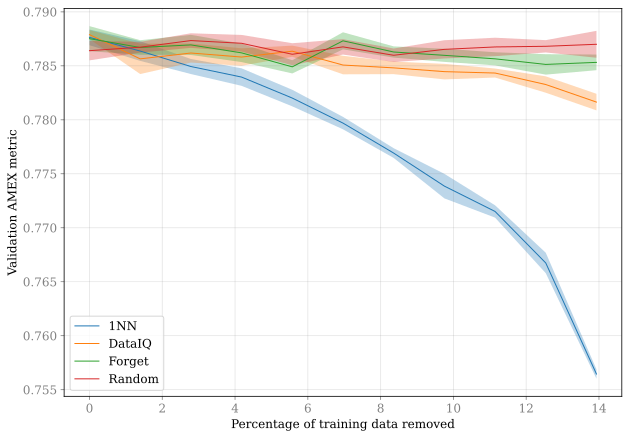

In [4]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('axes', grid=True)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)
plt.rc('ytick', direction='out', color='gray')
plt.rc('xtick', direction='out', color='gray')
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
n, k = 5000, 10
ns = [_ * n for _ in range(k + 1)]
frac_removed = [(1 - (len(X_train) - n) / len(X_train)) * 100 for n in ns]
ax.plot(frac_removed, knn_1_means, lw=1, label='1NN')
ax.fill_between(frac_removed, knn_1_means - 1.96 * np.array(knn_1_stds) / np.sqrt(10), knn_1_means + 1.96 * np.array(knn_1_stds) / np.sqrt(10), alpha=0.3)
ax.plot(frac_removed, knn_5_means, lw=1, label='5NN')
ax.fill_between(frac_removed, knn_5_means - 1.96 * np.array(knn_5_stds) / np.sqrt(10), knn_5_means + 1.96 * np.array(knn_5_stds) / np.sqrt(10), alpha=0.3)
ax.plot(frac_removed, knn_100_means, lw=1, label='100NN')
ax.fill_between(frac_removed, knn_100_means - 1.96 * np.array(knn_100_stds) / np.sqrt(10), knn_100_means + 1.96 * np.array(knn_100_stds) / np.sqrt(10), alpha=0.3)
ax.plot(frac_removed, dataiq_means, lw=1, label='DataIQ')
ax.fill_between(frac_removed, dataiq_means - 1.96 * np.array(dataiq_stds) / np.sqrt(10), dataiq_means + 1.96 * np.array(dataiq_stds) / np.sqrt(10), alpha=0.3)
#ax.plot(frac_removed, forget_means, lw=1, label='Forget')
# ax.fill_between(frac_removed, forget_means - 1.96 * np.array(forget_stds) / np.sqrt(10), forget_means + 1.96 * np.array(forget_stds) / np.sqrt(10), alpha=0.3)
ax.plot(frac_removed, rand_means, lw=1, label='Random')
ax.fill_between(frac_removed, rand_means - 1.96 * np.array(rand_stds) / np.sqrt(10), rand_means + 1.96 * np.array(rand_stds) / np.sqrt(10), alpha=0.3)
ax.set_xlabel('Percentage of training data removed')
ax.set_ylabel('Validation Gini')
ax.legend()
fig.savefig('../outputs/figures/compare_hardness.pdf', dpi=300, bbox_inches='tight')